# Chapter 9 自然语言理解

第八章节我们使用了seq2seq模型和注意力模型进行文本翻译，本章将介绍一种更加复杂的自然语言处理技术，以及一种用于自然语言处理的新模型：**Transfromer**。

## 9.1 Transformer简介

- Transformer模型主要由一个编码器和一个解码器组成，此结构与第八章使用的模型结构类似，主要区别在于编码器和解码器都不包含LSTM模型。Transformer模型的特征编码和解码阶段使用了由Keras设计的多层结构。多层结构的层数可由用户自行配置。
- 编码器包含一个特殊的注意力模块，称为多头注意力（Multi-head attention, MA）。解码器也包含此类注意力模块。解码器中包含另外一种名为Masked multi-Head attention（MMA）的注意力模块。
- Transformer中的特征提取过程与传统的特征提取方式不同，特征传递不是按照从编码器到解码器的串联方式进行的，而是将输入语句分为若干单词，以并联方式输入特征提取网络。上述数据输入方式被称为多头（multi-head）输入，此方式有助于分布式训练和推理。
- 除上述结构，书中图9-1的Transfromer结构使用了额外的嵌入（embedding）模块。通常在自然语言处理任务中使用词嵌入（word embedding）模块。在Transformer中，在输入的语句中加入了一个额外的嵌入模块，称为位置嵌入（positional emdedding）。位置嵌入用于指定特定单词在输入语句中的相对位置，其作用与LSTM结构中的编码器、解码器相同，因此Transformer模块不需要使用LSTM机制。

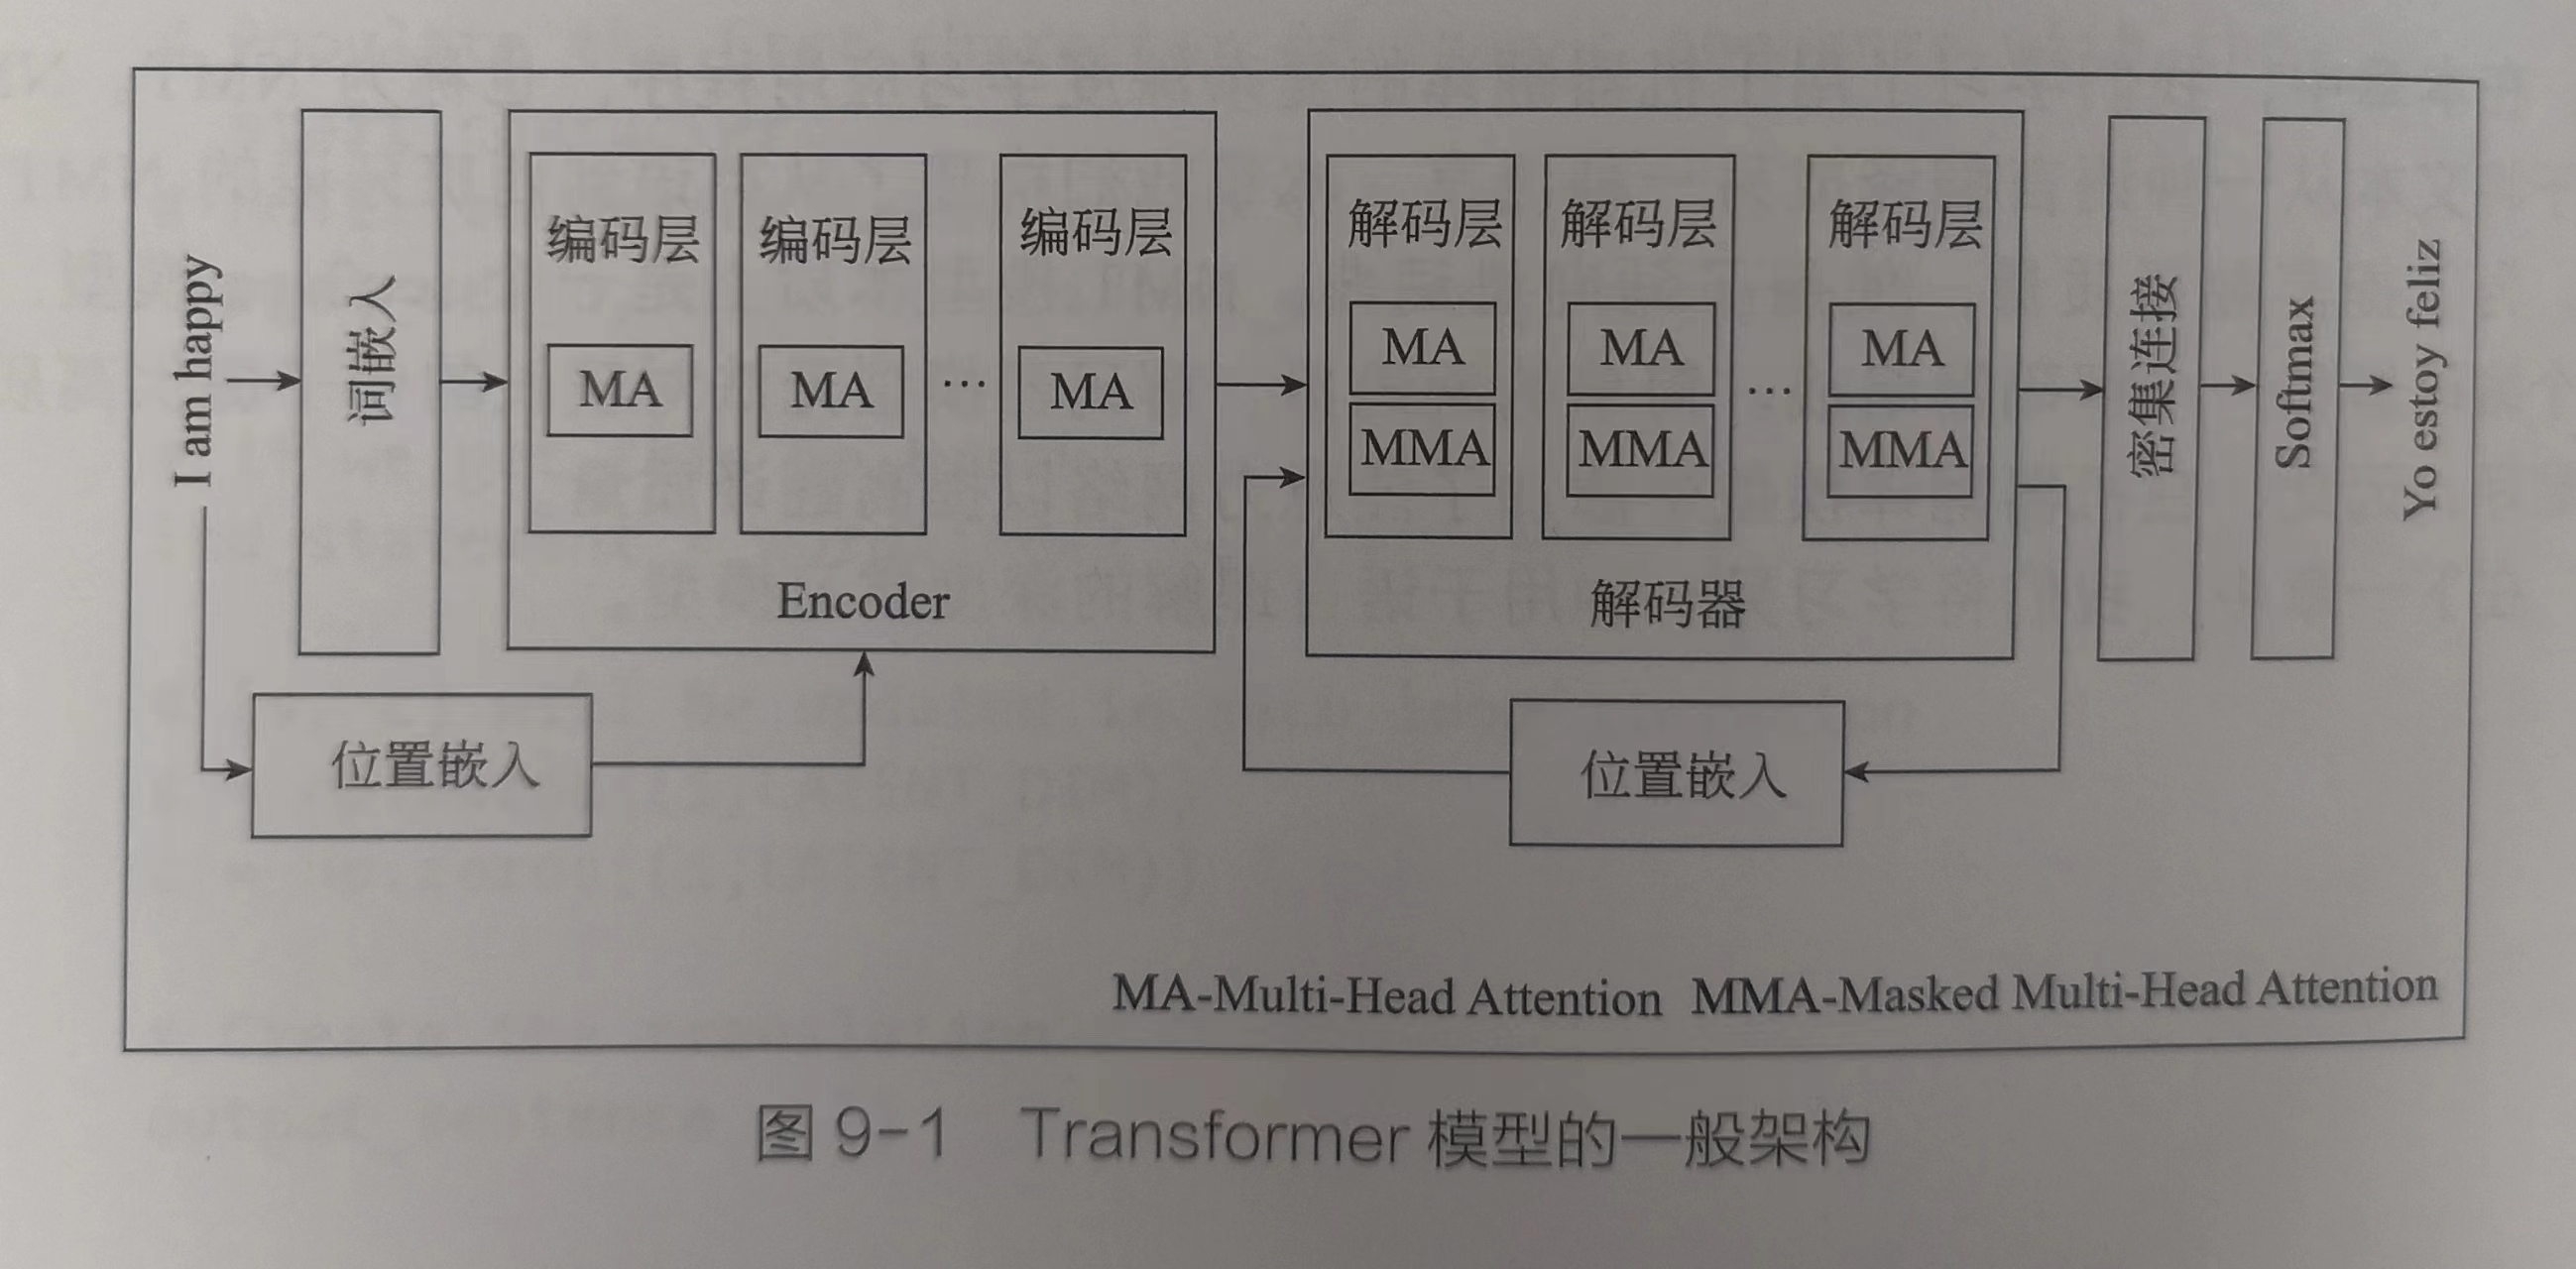

## 9.2 Transformer详解：NLP-transformer

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Bidirectional,RepeatVector,Concatenate,Activation,Dot,Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import preprocessing,utils
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import string

### 9.2.1 下载原始数据

In [ ]:
!pip install wget
import wget 
url = 'https://raw.githubusercontent.com/Apress/artificial-neural-networks-with-tensorflow-2/main/ch08/spa.txt'
wget.download(url,'spa.txt')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'spa (2).txt'

### 9.2.2 创建数据集

- 本章仅使用整个语料库的一个子集进行算法研究，约10000个样本。

In [ ]:
# reading data
with open('/content/spa.txt',encoding='utf-8',errors='ignore') as file:
  text=file.read().split('\n')

In [ ]:
input_texts=[] #encoder input
target_texts=[] # decoder input

In [ ]:
text[0:10]

['Go.\tVe.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)',
 'Go.\tVete.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)',
 'Go.\tVaya.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)',
 'Go.\tVáyase.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #6586271 (arh)',
 'Hi.\tHola.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #431975 (Leono)',
 'Run!\t¡Corre!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1685404 (Elenitigormiti)',
 'Run!\t¡Corran!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #5213896 (cueyayotl)',
 'Run!\t¡Corra!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8005613 (Seael)',
 'Run!\t¡Corred!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8005615 (Seael)',
 'Run.\tCorred.\tCC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #6681472 (arh)']

In [ ]:
text[0].split('\t')[:2]

['Go.', 'Ve.']

In [ ]:
# we will select subset of the whole data
NUM_SAMPLES = 10000 
for line in text[:NUM_SAMPLES]:
  english, spanish  = line.split('\t')[:2]
  target_text = spanish.lower()
  input_texts.append(english.lower())
  target_texts.append(target_text)

### 9.2.3 数据预处理

In [ ]:
input_texts[:10]

['go.', 'go.', 'go.', 'go.', 'hi.', 'run!', 'run!', 'run!', 'run!', 'run.']

In [ ]:
target_texts[:10]

['ve.',
 'vete.',
 'vaya.',
 'váyase.',
 'hola.',
 '¡corre!',
 '¡corran!',
 '¡corra!',
 '¡corred!',
 'corred.']

In [ ]:
regex = re.compile('[%s]' % re.escape(string.punctuation))
for s in input_texts:
  regex.sub('', s) 
for s in target_texts:
  regex.sub('', s)

In [ ]:

input_texts[:10],target_texts[:10]

(['go.', 'go.', 'go.', 'go.', 'hi.', 'run!', 'run!', 'run!', 'run!', 'run.'],
 ['ve.',
  'vete.',
  'vaya.',
  'váyase.',
  'hola.',
  '¡corre!',
  '¡corran!',
  '¡corra!',
  '¡corred!',
  'corred.'])

### 9.2.4 构建语料库

本章节使用SubWordTextEncoder类创建分词器。分词器将原始文本与文本编码（ID）关联，进行字典构造。如果存在特殊文本不在现有字典中，分词将其分解为若干子词进行处理。

In [ ]:
tokenizer_input = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    input_texts, target_vocab_size=2**13)
# 第二个参数可以指定任意大的值

In [ ]:
tokenizer_input

<SubwordTextEncoder vocab_size=2974>

In [ ]:
# 测试分词器的有效性
# example showing how this tokenizer works
tokenized_string1=tokenizer_input.encode('hello i am good')
tokenized_string1

[2269, 1, 41, 89]

In [ ]:
for token in tokenized_string1:
  print ('{} ----> {}'.format(token, tokenizer_input.decode([token])))

2269 ----> hello 
1 ----> i 
41 ----> am 
89 ----> good


In [ ]:
# if the word is not in dictionary
tokenized_string2=tokenizer_input.encode('how is the moon')
for token in tokenized_string2:
  print ('{} ----> {}'.format(token, tokenizer_input.decode([token])))

64 ----> how 
4 ----> is 
21 ----> the 
2827 ----> m
2829 ----> o
75 ----> on


- 以同样的方法处理翻译目标语言。

In [ ]:
# tokenize Spanish text
tokenizer_out=tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    target_texts, target_vocab_size=2**13)

- 为输入语句和输出语句添加起始和结束标记，使用如下代码实现。

In [ ]:
START_TOKEN_in=[tokenizer_input.vocab_size] #input start token
END_TOKEN_in=[tokenizer_input.vocab_size+1]#input end token
START_TOKEN_out=[tokenizer_out.vocab_size]#output start token
END_TOKEN_out=[tokenizer_out.vocab_size+1]#output end token/

In [ ]:
START_TOKEN_in,END_TOKEN_in,START_TOKEN_out,END_TOKEN_out

([2974], [2975], [5737], [5738])

- 编写一个用于填充输入数据集和输出数据集的函数，将最大长度设为10，用于构建相同长度的输入和输出语句。

In [ ]:
MAX_LENGTH = 10

# Tokenize, filter and pad sentences
def tokenize_and_padding(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (input_sentence, output_sentence) in zip(inputs, outputs):
    # tokenize sentence
    input_sentence = START_TOKEN_in + tokenizer_input.encode(input_sentence) + END_TOKEN_in
    output_sentence = START_TOKEN_out + tokenizer_out.encode(output_sentence) + END_TOKEN_out
    # check tokenized sentence max length
    #if len(input_sentence) <= MAX_LENGTH and len(output_sentence) <= MAX_LENGTH:
    tokenized_inputs.append(input_sentence)
    tokenized_outputs.append(output_sentence )
  
  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

english, spanish = tokenize_and_padding(input_texts,target_texts)

In [ ]:
np.shape(english)

(10000, 10)

In [ ]:
spanish

array([[5737, 1482, 5527, ...,    0,    0,    0],
       [5737, 1017, 5527, ...,    0,    0,    0],
       [5737,  772, 5527, ...,    0,    0,    0],
       ...,
       [5737, 2309,   36, ...,    0,    0,    0],
       [5737,  376,   74, ...,    0,    0,    0],
       [5737,   57,   24, ...,    0,    0,    0]], dtype=int32)

### 9.2.5 准备训练集数据

- 准备用于训练的数据集，为了创建数据输入管道，使用tf.data.Dataset函数提供的cache和prefetch等功能加快数据输入进程。


In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 10000

# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': english,
        'decoder_inputs': spanish[:, :-1]
    },
    {
        'outputs':spanish[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)# 在预处理数据和模型执行数据之间并行提取数据，当模型执行第n个训练时，输入管道读取第n+1个步骤的数据。上述过程可加快训练进程。

### 9.2.6 Transformer模型

- Transformer模型由多个组件构成，构建完整模型依赖于创建各部分组件。为了更好的理解模型构建方式，首先概述模型的主要组件，然后深入了解每个组件及其详细的实现细节。本章项目代码基于Transformer Chatbot实现。直接使用已有代码进行讲解。
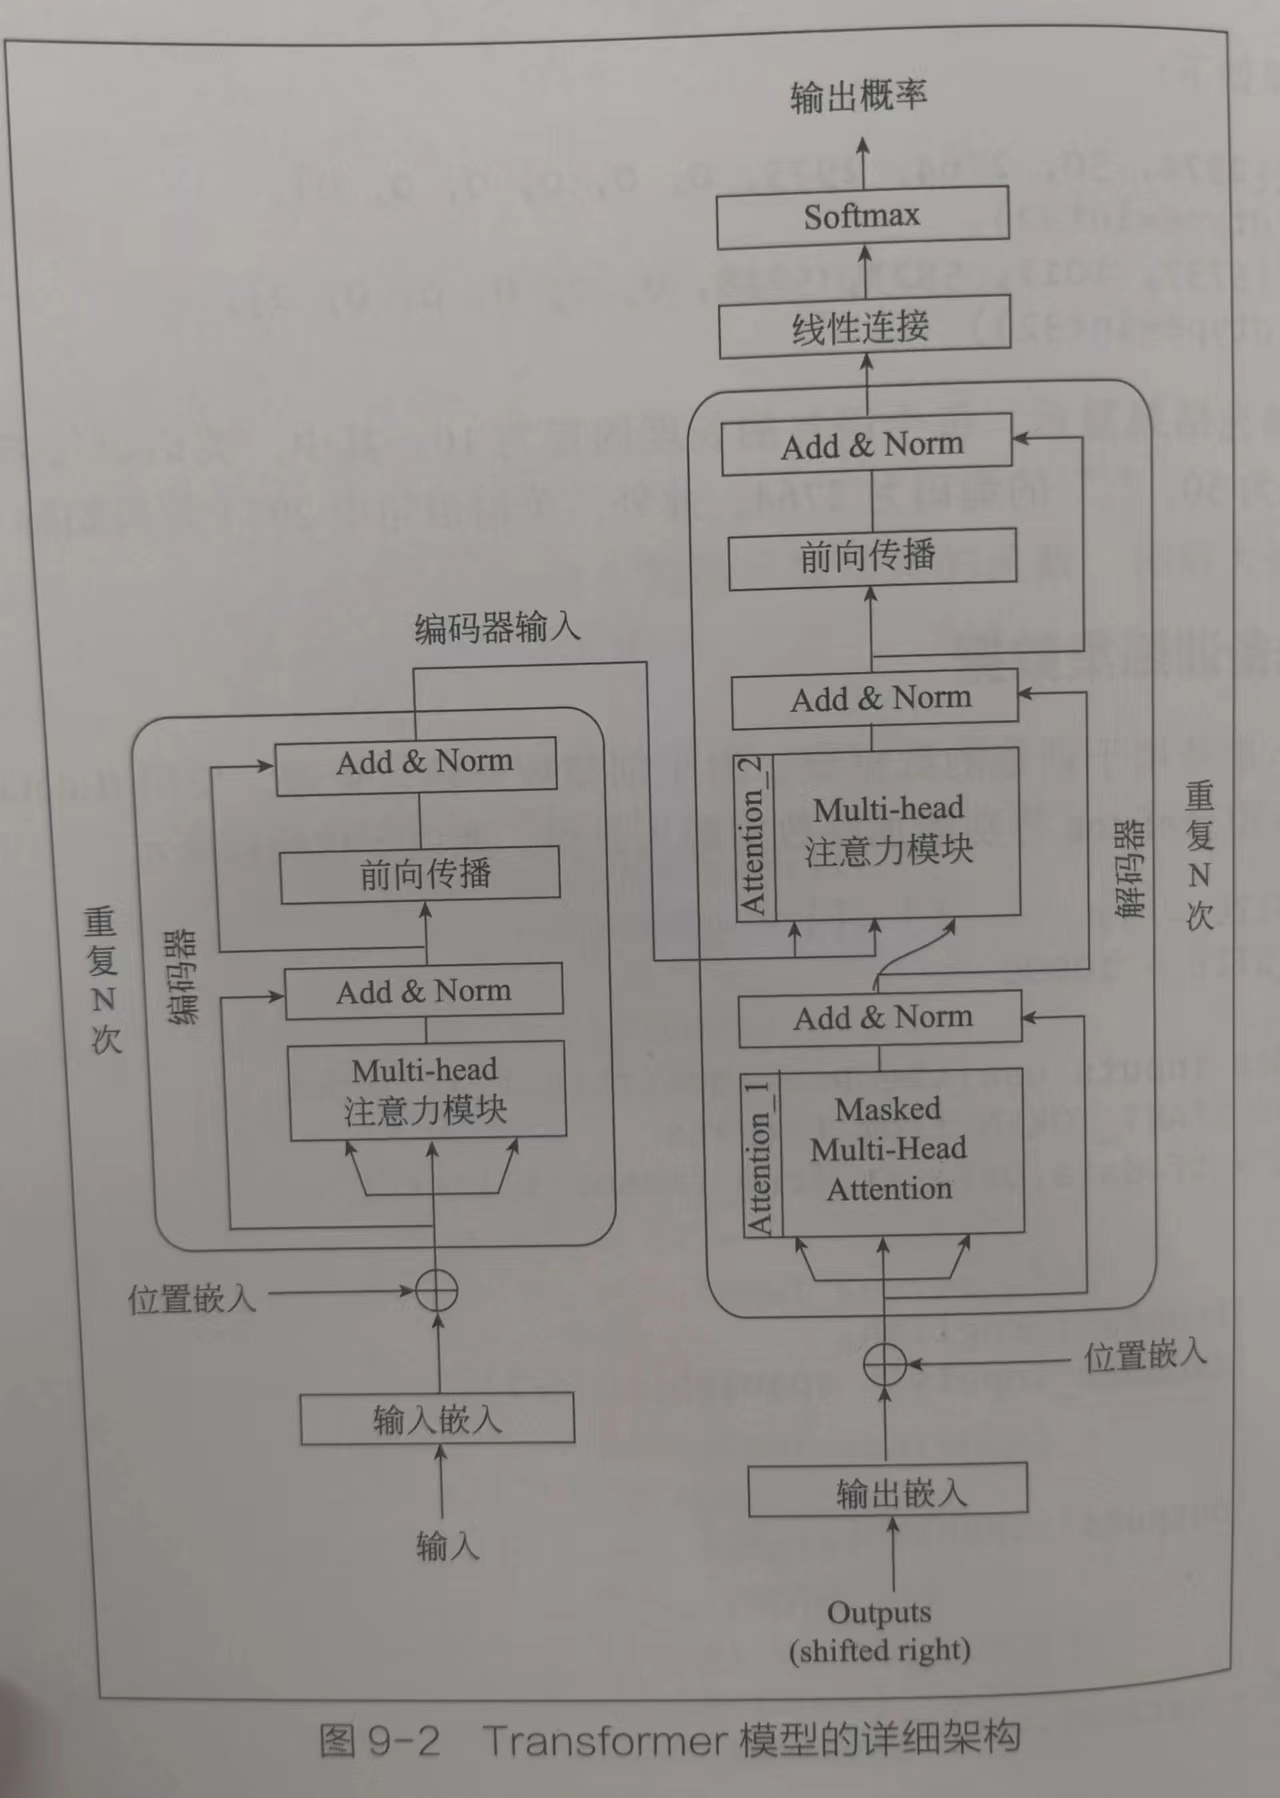
- Transformer模型主要由一个编码器、一个解码器和若干多头注意力（机制）模块组成。其中，多头注意力模块（机制）是整个架构的核心模块。



### 9.2.7 多头注意力

多头注意力是Transformer的核心，以网络层的形式出现在Transformer中，Transformer结构多次使用多头注意力。因此为多头注意力机制编写了一个类，该类派生自Keras.Layer类。多头注意力示意图如下图9-3所示。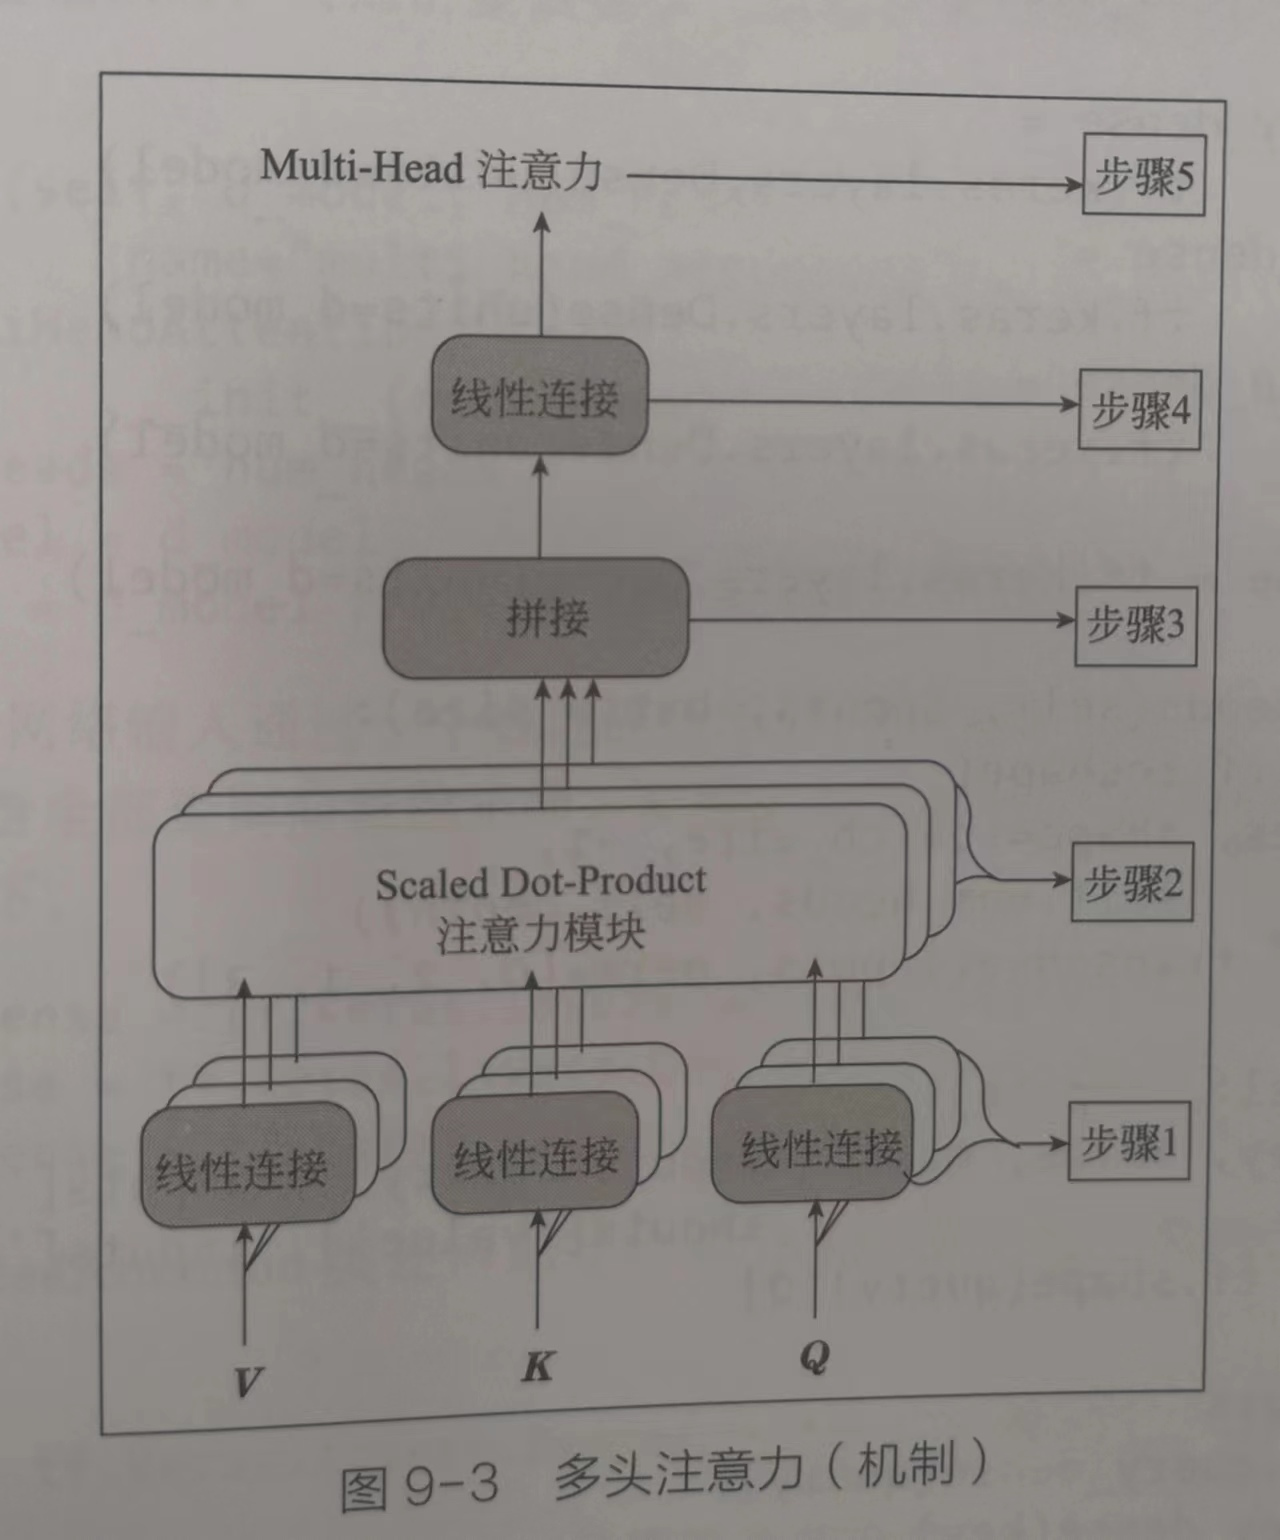

- 图9-3中的多头注意力有三部分输入，即Q(query),K(key),V(value)。这3个向量被分成多个输入头，并通过线性连接层传递给下一步，通过这种方式，Transformer模型可以同时处理输入句子中的多个单词，促进分布式训练。

- 对图9-3中的每个输入向量使用按比例缩放的点积注意力模块（Scaled Dot-Product），并根据是否在编码器或解码器中使用多头注意力，对多头注意力进行编码。后续介绍两种常用的编码方式。

- 接下来，Scaled Dot-Product注意力模块的输出使用tf.transpose
函数和tf.reshape函数连接起来，并通过一个线性连接层（Linear）产生最终注意力向量。

- 多头注意力原理图由5个主要组件实现。编号为步骤1-步骤5，在Transfromer代码中通过定义MultiHeadAttention类实现。



In [ ]:
# MultiHeadAttention类的实现

class MultiHeadAttention(tf.keras.layers.Layer):
  
  # 类构造函数的定义
  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    # 将传递的参数存储在类变量中以备后用
    self.num_heads = num_heads
    self.d_model = d_model
    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)#Q为包含全部查询向量的矩阵
    self.key_dense = tf.keras.layers.Dense(units=d_model)#K和V为序列中所有单词的向量表示。
    self.value_dense = tf.keras.layers.Dense(units=d_model) 
    self.dense = tf.keras.layers.Dense(units=d_model)# 用于获得注意力模型的输出
  
  # 对输入句子中的不同单词进行并行处理，有利于分布式训练。split_heads函数对数据进行整形、转置，并将处理后的输入数据返回给调用函数。代码如下：
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  # 通过函数调用构建了整个Transformer网络。
  def call(self, inputs):

    # 首先将输入数据分为四部分
    query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    # 为三组输入数据（Q，K，V）创建线性连接层
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads拆分输入数据
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    # 计算Scaled Dot-Product注意力模块输出，即图9-3中的步骤3.
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    # 连接各组输入数据的计算结果。
    concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))

    # final linear layer
    # 定义线性连接输出层。
    outputs = self.dense(concat_attention)

    return outputs

### 9.2.8 Scaled Dot-Product注意力模块

- Transformer使用的Scaled Dot-Product模块接受三组输入数据（Q，K，V），使用如下方程计算：

$Attention(Q,K,V)=softmax_k(\frac{QK^T}{\sqrt{d_k}})V$

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):

  # 首先计算QK^T.
  QxK_transpose = tf.matmul(query, key, transpose_b=True)

  #计算QK^T/sqrt(dk)
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = QxK_transpose / tf.math.sqrt(depth)

  if mask is not None:
    logits += (mask * -1e9)

  #通过softmax激活
  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)
  
  #计算注意力的权重和输入向量V之间的矩阵乘法得到输出结果。
  output = tf.matmul(attention_weights, value)

  return output

9.2.9 编码器结构
- 结构如图9-4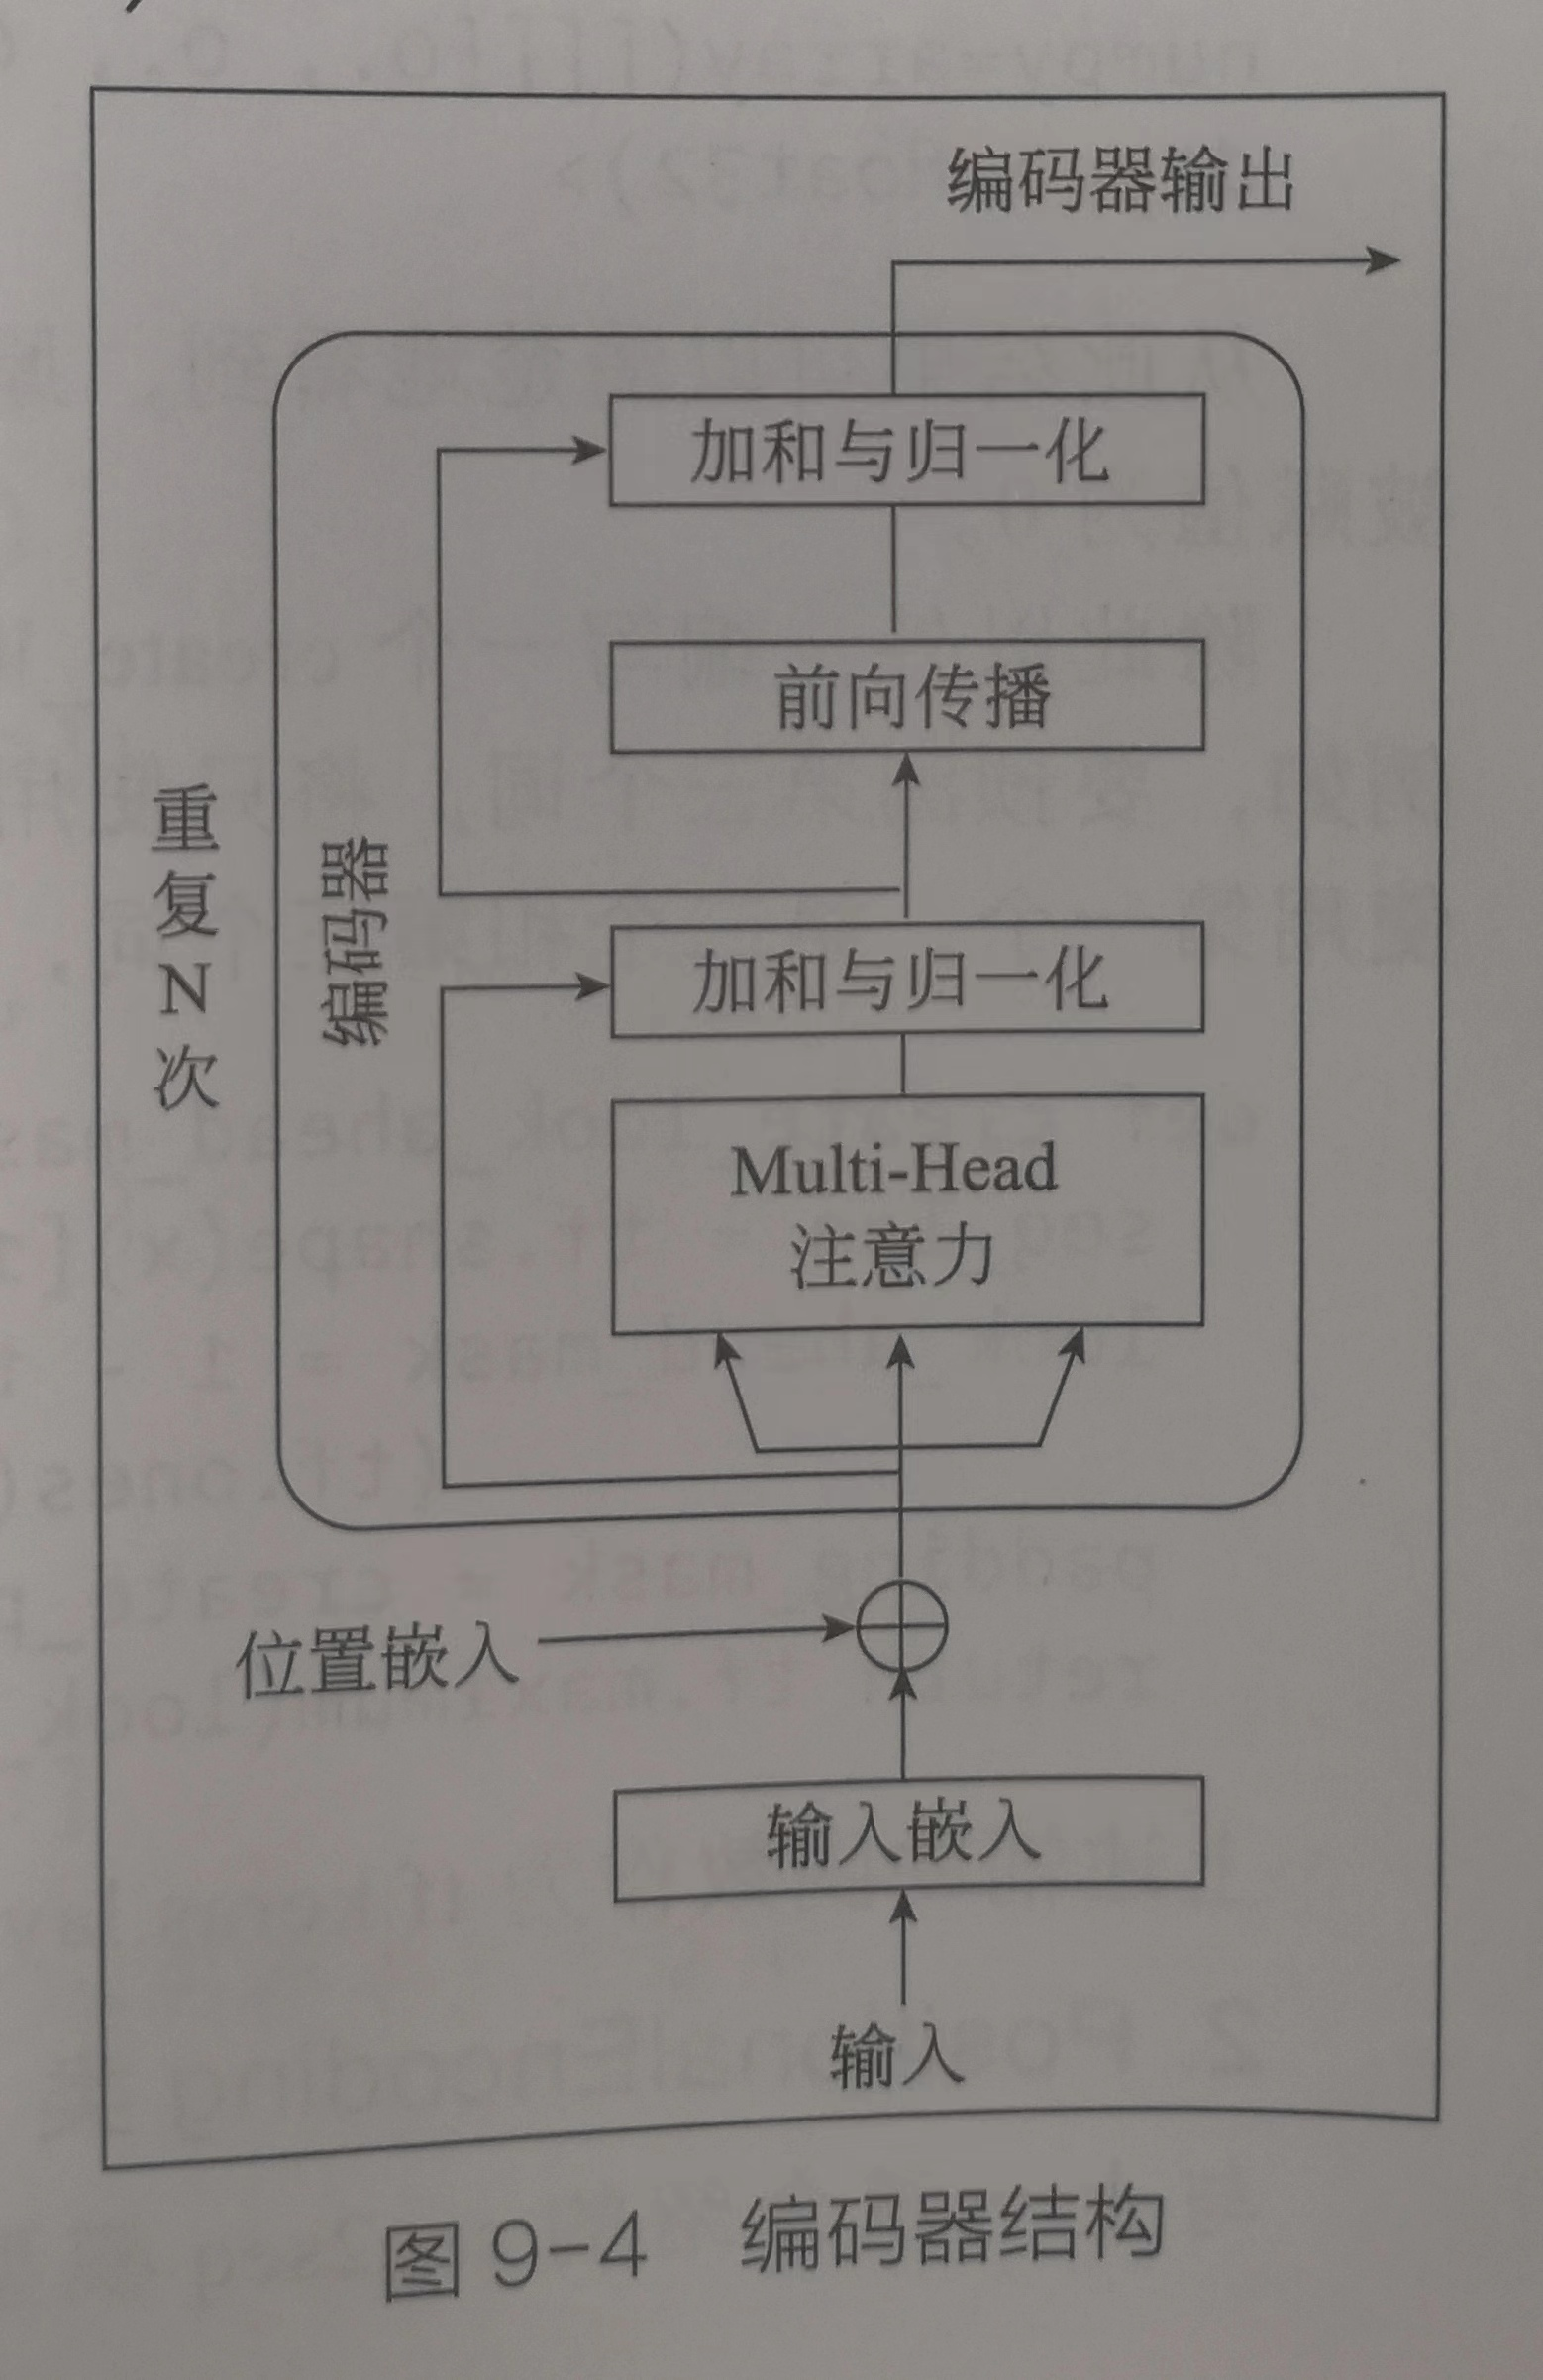

- 如上图，编码器包含由一个Keras定义的编码层，编码器在Transformer中重复N次，进一步讲，编码器由若干层组成。其中包括之前定义的多头注意力机制、加和与归一化层、前向传播层。编码器接收由输入嵌入模块和位置嵌入模块编码后的输入数据。位置嵌入模块定义单词在句子中的相对位置，给出单词的位置编码。在定义编码层之前，定义两个辅助函数，用于位置编码和屏蔽预处理数据中的填充标记。

- 1. 定义create_padding_mask函数
 - 输入数据预处理时，网络可能会对输入语句进行填充处理，补0，并将补0后的语句作为网络输入。
 - 我们不希望模型将所有的零值作为有效输入，需要编写一个函数屏蔽语料编码后添加的额外填充值。

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [34]:
# function testing
x=tf.constant([[2974,   50, 2764, 2975,    0,    0,    0,    0,    0,    0]])
create_padding_mask(x)

<tf.Tensor: shape=(1, 1, 1, 10), dtype=float32, numpy=array([[[[0., 0., 0., 0., 1., 1., 1., 1., 1., 1.]]]], dtype=float32)>

In [36]:
# 定义语料库中的无用单词。例如要预测第三个单词，只使用第一个和第二个单词。
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

- 2. PositionalEcoding类
  - 为了提供给定句子中单词相对位置信息，向Transformer网络提供了位置编码的附加输入。将两个向量：位置编码和位置嵌入，一起输入到Transformer网络中。位置嵌入将具有相似含义的单词聚集在一起，但不指定单词在句子中的相对位置。将位置编码结果和位置嵌入结果相加可以根据单词含义的相似性和他们在句子中的位置使单词更接近。
  - 计算位置编码的公式如下：
  - $PE_{(pos,2i)}=sin(pos/10000^{2i/d_model})$
  - $PE_{(pos,2i+1)}=cos(pos/10000^{2i/d_model})$
  

In [37]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sine to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cosine to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

- 3. 编码层
  
  - 如图9-4所示，重复N次的编码层由以下几部分组成。
    - （1）多头注意力机制。
    - （2）两个Dense层及dropout层。
    
    上述两部分均含有归一化层，用于处理梯度消失问题。

In [38]:
 def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # multi-head attention with padding mask
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # two dense layers followed by a dropout
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 9.2.10 编码器

- 编码器由：输入嵌入模块(input embedding)、位置嵌入模块(position embedding)、编码层。
- 编码层的重复次数可以根据需要定义。本项目中重复次数为2次。第一个编码层的输入是输入嵌入和位置编码的总和，第二个编码层的输出为编码器的最终输出，也是解码器的输入。

In [39]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  # create padding mask
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # create combination of word embedding + positional encoding
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))# 在两个嵌入层之间共享了权重矩阵，将这些权重与变量d_model的平方根相乘后输入到PositionalEncoding中。
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # repeat the Encoder Layer two times
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

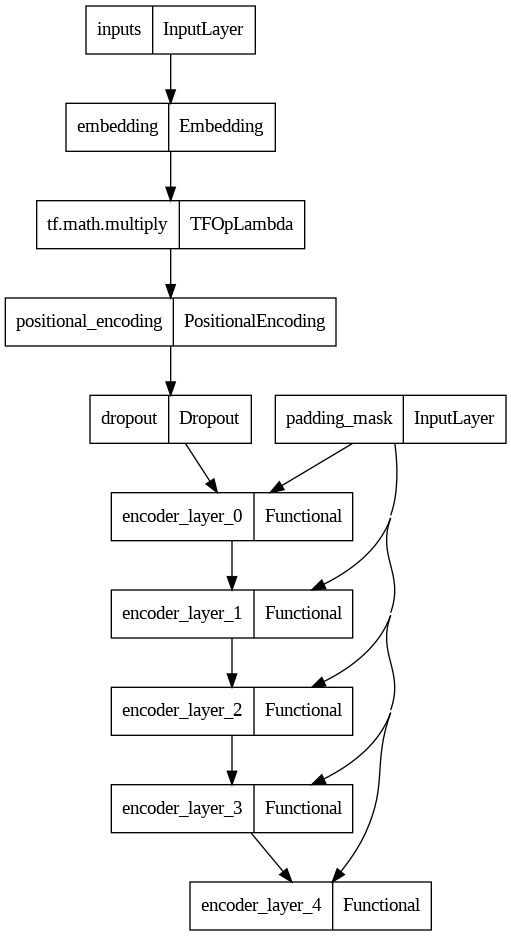

In [40]:
# 使用如下代码生成编码器模型图
sample_encoder = encoder(
    vocab_size=8192,
    num_layers=5,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder")

tf.keras.utils.plot_model(
   sample_encoder, to_file='encoder.png')

### 9.2.11 解码器结构

- 解码器的输入是编码器的输出。解码器也是由重复的解码层组成。解码器第一层接收来自编码器的输入，最后一层通过线性连接层及Softmax层，得到目标单词的输出概率。解码器的其他输入时输出词嵌入和位置编码的组合。接下来，描述可重复的解码层构造。

- 解码层包含两个多头注意力层：
  - 多头注意力（机制）（Attention_2）
    - Attention2接收来自编码器的输出作为输入，输出K向量和V向量。此注意力的另一个输入为Masked多头注意力的输出。
  - Masked多头注意力(Attention_1)
    - Attention1,使用Masked前缀的原因是它的输入为前一个解码器输出和位置编码的组合。
- Attention2的输出经过两个线性连接层及dropout层。上述为解码层的结构。解码层在解码器中重复N次。




In [41]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

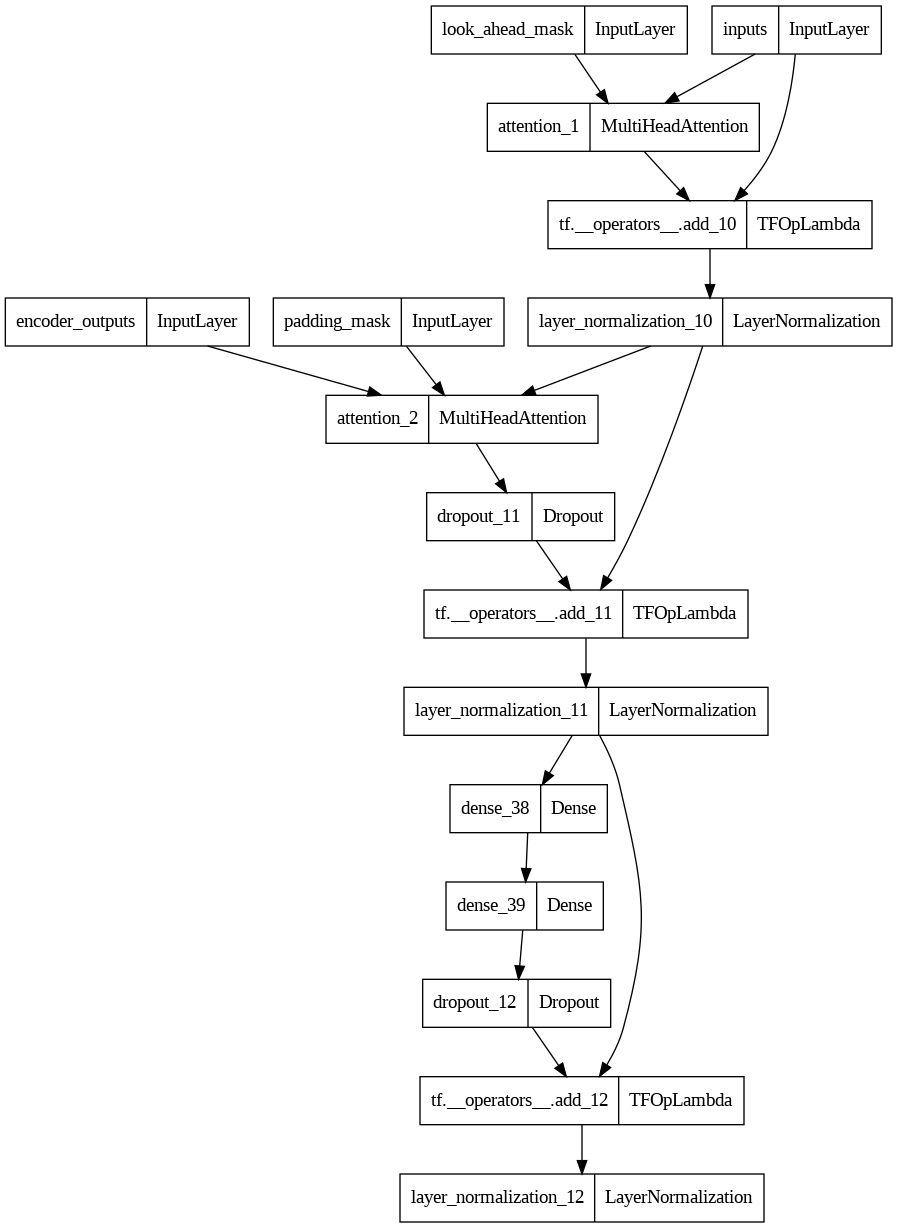

In [42]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png')

### 9.2.12 定义解码器

与编码器情况一样，解码器网络是通过将解码层重复N次完成构建的。之前讲解了解码器的各个输入，解码器的输出经过线性连接层和softmax分类层得到。

The Decoder consists of:

- Output Embedding
- Positional Encoding
- N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [45]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropodatasetut,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

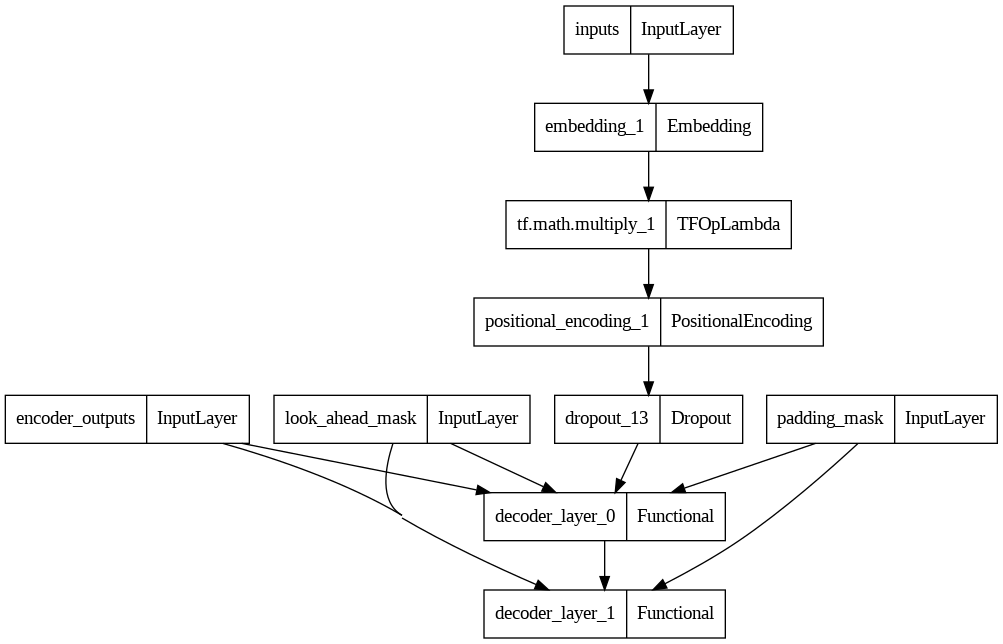

In [46]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png')

### 9.2.13 Transformer模型

- Transformer模型由**编码器**、**解码器**和最终的**线性连接层**组成。解码器的输出是线性连接层的输入。

In [49]:
def transformer(input_vocab_size,
        target_vocab_size,
        num_layers,
        units,
        d_model,
        num_heads,
        dropout,
        name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="decoder_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=input_vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=target_vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=target_vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

- 查看transformer架构

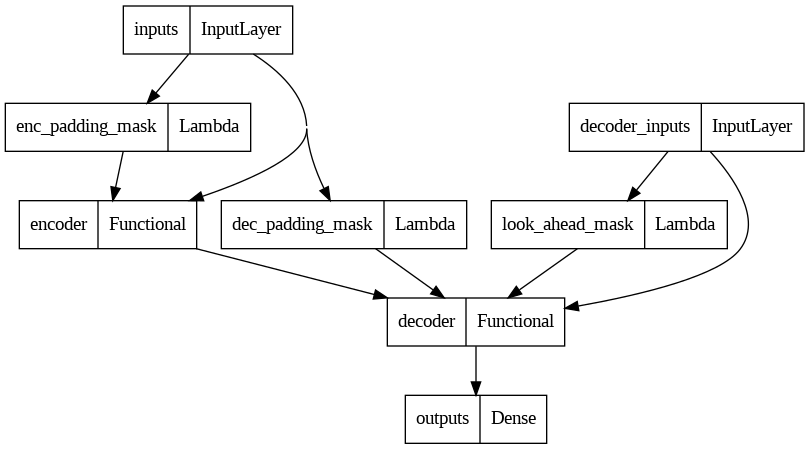

In [50]:
sample_transformer = transformer(
    input_vocab_size = 100,
    target_vocab_size = 100,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png')

- 由上图，Transformer结构简单易懂，主要包含一个编码器和一个解码器。定义了Transformer模型以后，需要进行模型创建和编译工作。

### 9.2.14 创建训练模型

In [51]:
# 实例化Transformer类：
D_MODEL = 256
model = transformer(
    tokenizer_input.vocab_size+2,
    tokenizer_out.vocab_size+2,
    num_layers = 2,
    units = 512,
    d_model = D_MODEL,
    num_heads = 8,
    dropout = 0.1)

### 9.2.15 损失函数

使用稀疏分类熵函数测量模型输出的预测值y和真实值之间的差异。

In [52]:
def loss(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, 10 - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### 9.2.16 优化器

- 使用Adam优化器来训练模型。建议对优化器使用自定义学习率。自定义学习率由以下等式计算。

$lrate=d_{model}^{-0.5}min(step\_num^{-0.5},step\_num*warmup\_steps^{-1.5})$

- 根据以上方程，学习率最初会随着训练次数的增加而线性增加，随后学习率的变化与训练次数的平方根成正比。本项目中warmup_steps为4000。

- 为了实现学习率变化公式，创建了一个CustomSchedule类。



In [74]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    # self.d_model = tf.cast(self.d_model, tf.float32)\
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)# https://github.com/TensorSpeech/TensorFlowASR/issues/142  
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### 9.2.17 编译


In [76]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [78]:
model.compile(optimizer=optimizer, loss=loss)

### 9.2.18 训练

调用fit方法训练模型。


In [79]:
EPOCHS = 20
model.fit(dataset,epochs=EPOCHS)

Epoch 2/20
313/313 [==============================] - 79s 252ms/step - loss: 2.3052
Epoch 3/20
313/313 [==============================] - 106s 340ms/step - loss: 1.8162
Epoch 4/20
313/313 [==============================] - 101s 321ms/step - loss: 1.5265
Epoch 5/20
313/313 [==============================] - 84s 269ms/step - loss: 1.3065
Epoch 6/20
313/313 [==============================] - 75s 241ms/step - loss: 1.1182
Epoch 7/20
313/313 [==============================] - 75s 240ms/step - loss: 0.9584
Epoch 8/20
313/313 [==============================] - 78s 248ms/step - loss: 0.8276
Epoch 9/20
313/313 [==============================] - 77s 245ms/step - loss: 0.7246
Epoch 10/20
313/313 [==============================] - 75s 240ms/step - loss: 0.6466
Epoch 11/20
313/313 [==============================] - 77s 245ms/step - loss: 0.5903
Epoch 12/20
313/313 [==============================] - 75s 241ms/step - loss: 0.5483
Epoch 13/20
313/313 [==============================] - 74s 236ms/step -

### 9.2.19 预测

本项目将给定的英语句子翻译成德语。通过创建名为translate的函数实现。首先使用之前介绍的预处理方法对输入语句进行编码，并向其中添加开始和结束标记。由变量MAX_LENGTH定义语句的最长长度为10.因此创建了一个循环一迭代的方式输入10个单词。注意力机制给出每个单词在全句中的重要程度，逐词进行语句翻译。translate函数代码如下：

In [80]:
def translate (input_sentence):
  
  input_sentence = START_TOKEN_in + tokenizer_input.encode(input_sentence) + END_TOKEN_in
  encoder_input = tf.expand_dims(input_sentence, 0)
 
  decoder_input = [tokenizer_out.vocab_size]
  output = tf.expand_dims(decoder_input, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[encoder_input, output], training=False)

    # select the last word
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # terminate on END_TOKEN
    if tf.equal(predicted_id, END_TOKEN_out[0]):
      break

    # concatenated the predicted_id to the output 
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

### 9.2.20 测试

使用真实语句测试Transformer模型。设置一组输入句子，并定义一个循环测试代码执行翻译。将翻译结果在控制台上打印输出。

In [81]:
test_sentences = ['i am sorry', 'how are you']
for s in test_sentences:
  prediction = translate(s)

  predicted_sentence = tokenizer_out.decode(
      [i for i in prediction if i < tokenizer_out.vocab_size])

  print('Input: {}'.format(s))
  print('Output: {}'.format(predicted_sentence))

Input: i am sorry
Output: lo siento.
Input: how are you
Output: qué sos tú.
